C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_11988\888961125.py:23: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_11988\888961125.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_11988\888961125.py:79: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



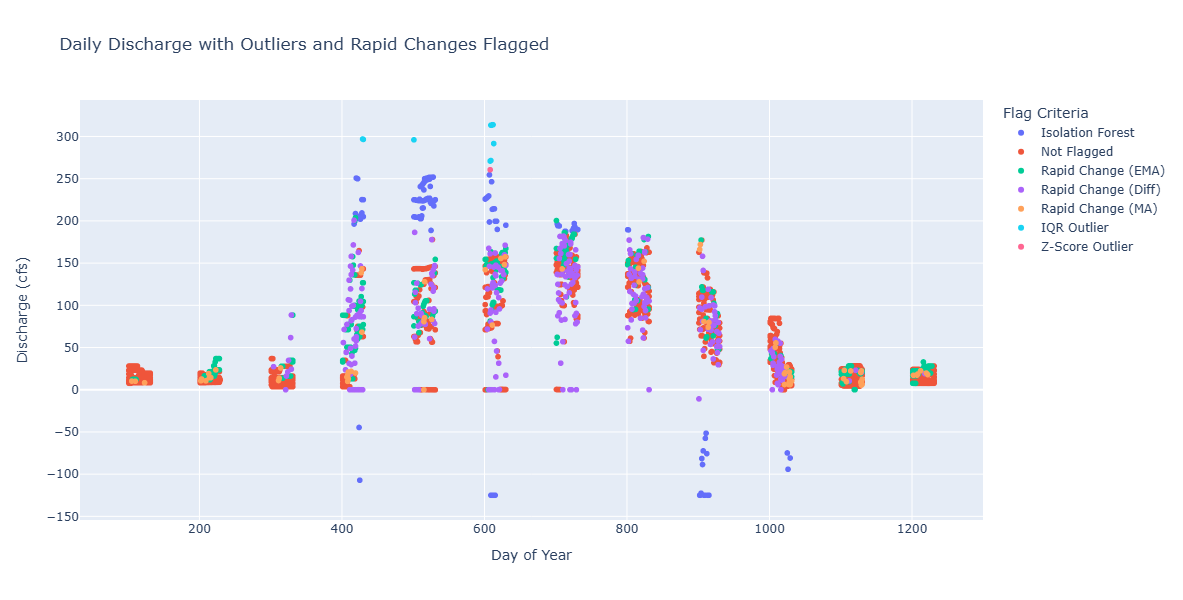

In [2]:
import pyodbc
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

# Database connection parameters
server = 'wrt-sql-prod'
database = 'dvrtDB'
username = 'wrtsqlq'
password = 'guest'

# Establish connection and fetch data
with pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password}"
) as conn:
    query = "SELECT * FROM dbo.DAILY_RECORDS WHERE STATION_ID = 10987"
    df = pd.read_sql_query(query, conn)

# Convert wide format to long format
df_long = df.melt(id_vars=['STATION_ID', 'RECORD_YEAR'], 
                  var_name='DAY', value_name='DISCHARGE')

# Extract numeric day values (from RV_0101 format)
df_long['DAY'] = df_long['DAY'].str.extract(r'RV_(\d{4})').astype(int)

# Convert DISCHARGE to numeric and keep NaNs
df_long['DISCHARGE'] = pd.to_numeric(df_long['DISCHARGE'], errors='coerce')

# Sort data for proper time series plotting
df_long = df_long.sort_values(['RECORD_YEAR', 'DAY'])

# Compute rate of change (grouped by year)
df_long['DISCHARGE_CHANGE'] = df_long.groupby('RECORD_YEAR')['DISCHARGE'].diff()

# ------------------------------------------------------
# Outlier Detection Techniques

# 1. IQR method for outlier detection
Q1 = df_long['DISCHARGE'].quantile(0.25)
Q3 = df_long['DISCHARGE'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold_lower = Q1 - 1.5 * IQR
outlier_threshold_upper = Q3 + 1.5 * IQR

# Flag outliers using IQR
df_long['OUTLIER_IQR'] = (df_long['DISCHARGE'] < outlier_threshold_lower) | (df_long['DISCHARGE'] > outlier_threshold_upper)
df_long['OUTLIER_IQR'] = df_long['OUTLIER_IQR'].astype(bool)  # Ensure it's a boolean

# 2. Z-Score method for outlier detection
df_long['Z_SCORE'] = zscore(df_long['DISCHARGE'], nan_policy='omit')
df_long['OUTLIER_Z'] = (df_long['Z_SCORE'].abs() > 3)
df_long['OUTLIER_Z'] = df_long['OUTLIER_Z'].astype(bool)  # Ensure it's a boolean

# 3. Modified Z-Score (using Median and Median Absolute Deviation)
median = df_long['DISCHARGE'].median()
mad = np.median(np.abs(df_long['DISCHARGE'] - median))
df_long['MOD_Z_SCORE'] = 0.6745 * (df_long['DISCHARGE'] - median) / mad
df_long['OUTLIER_MOD_Z'] = df_long['MOD_Z_SCORE'].abs() > 3.5  # Threshold of 3.5 for modified Z-score
df_long['OUTLIER_MOD_Z'] = df_long['OUTLIER_MOD_Z'].astype(bool)  # Ensure it's a boolean

# 4. Isolation Forest for outlier detection (applied to 'DISCHARGE')
# Drop rows with NaN in the 'DISCHARGE' column before applying Isolation Forest
df_long_clean = df_long.dropna(subset=['DISCHARGE'])

# Fit the Isolation Forest model
model = IsolationForest(contamination=0.05)  # Adjust contamination parameter as needed
df_long_clean['OUTLIER_IF'] = model.fit_predict(df_long_clean[['DISCHARGE']])

# Add the 'OUTLIER_IF' column to the original dataframe (initialize it with 1, meaning inliers)
df_long['OUTLIER_IF'] = 1  # Default value of 1 (inliers)

# Mark -1 as outliers (from Isolation Forest)
df_long.loc[df_long_clean.index, 'OUTLIER_IF'] = df_long_clean['OUTLIER_IF'] == -1
df_long['OUTLIER_IF'] = df_long['OUTLIER_IF'].astype(bool)  # Ensure it's a boolean

# ------------------------------------------------------
# Rapid Change Detection Techniques

# 1. Differencing: Check if the difference between consecutive values exceeds 95th percentile
roc_95th_percentile = np.percentile(df_long['DISCHARGE_CHANGE'].dropna(), 95)
df_long['RAPID_CHANGE_DIFF'] = df_long['DISCHARGE_CHANGE'].abs() > roc_95th_percentile
df_long['RAPID_CHANGE_DIFF'] = df_long['RAPID_CHANGE_DIFF'].astype(bool)  # Ensure it's a boolean

# 2. Moving Average and Standard Deviation (using a window size of 7)
rolling_mean = df_long['DISCHARGE'].rolling(window=7, min_periods=1).mean()
rolling_std = df_long['DISCHARGE'].rolling(window=7, min_periods=1).std()
threshold = rolling_mean + 2 * rolling_std  # 2 standard deviations above the rolling mean
df_long['RAPID_CHANGE_MA'] = df_long['DISCHARGE'] > threshold
df_long['RAPID_CHANGE_MA'] = df_long['RAPID_CHANGE_MA'].astype(bool)  # Ensure it's a boolean

# 3. Exponential Moving Average (EMA) with a span of 7 days
ema = df_long['DISCHARGE'].ewm(span=7, adjust=False).mean()
df_long['RAPID_CHANGE_EMA'] = df_long['DISCHARGE'] > ema * 1.05  # 5% deviation above EMA
df_long['RAPID_CHANGE_EMA'] = df_long['RAPID_CHANGE_EMA'].astype(bool)  # Ensure it's a boolean

# ------------------------------------------------------
# Combine all flags for both outliers and rapid changes
df_long['FLAGGED'] = (
    df_long['OUTLIER_IQR'] |
    df_long['OUTLIER_Z'] |
    df_long['OUTLIER_MOD_Z'] |
    df_long['OUTLIER_IF'] |
    df_long['RAPID_CHANGE_DIFF'] |
    df_long['RAPID_CHANGE_MA'] |
    df_long['RAPID_CHANGE_EMA']
)

# Create a new column for Flag Criteria in legend
df_long['FLAG_CRITERIA'] = np.select(
    [
        df_long['OUTLIER_IQR'], 
        df_long['OUTLIER_Z'], 
        df_long['OUTLIER_MOD_Z'], 
        df_long['OUTLIER_IF'], 
        df_long['RAPID_CHANGE_DIFF'],
        df_long['RAPID_CHANGE_MA'],
        df_long['RAPID_CHANGE_EMA']
    ],
    [
        'IQR Outlier', 
        'Z-Score Outlier', 
        'Modified Z-Score', 
        'Isolation Forest', 
        'Rapid Change (Diff)', 
        'Rapid Change (MA)', 
        'Rapid Change (EMA)'
    ],
    default='Not Flagged'
)

# Create an interactive plot showing the discharge with flagged outliers and rapid changes
fig = px.scatter(
    df_long, 
    x='DAY', 
    y='DISCHARGE', 
    color='FLAG_CRITERIA', 
    title="Daily Discharge with Outliers and Rapid Changes Flagged",
    labels={'DISCHARGE': 'Discharge (cfs)', 'DAY': 'Day of Year'}
)

# Adjust graph size and legend title
fig.update_layout(
    legend_title="Flag Criteria",
    width=1200,  # Adjust the width as needed
    height=600   # Adjust the height as needed
)

fig.show()

# Optional: Save flagged data to a CSV file
df_long[df_long['FLAGGED']].to_csv("flagged_data_multiple_outliers.csv", index=False)

In [4]:
import pyodbc
import pandas as pd

# Database connection parameters
server = 'wrt-sql-prod'
database = 'dvrtDB'
username = 'wrtsqlq'
password = 'guest'

# Establish connection and fetch data
with pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password}"
) as conn:
    query = "SELECT * FROM dbo.DAILY_RECORDS WHERE STATION_ID = 10987"
    df = pd.read_sql_query(query, conn)

# Convert from wide to long format
df_long = df.melt(id_vars=['STATION_ID', 'RECORD_YEAR'], 
                  var_name='Day', value_name='Discharge (CFS)')

# Extract and format the 'Day' column
df_long['Day'] = df_long['Day'].str.extract(r'(RV_\d{4})')  # Keep the RV_XXXX format
df_long['Day_Number'] = df_long['Day'].str[3:].astype(int)  # Extract numeric day (0101 -> 101)

# Create a proper 'Date' column
df_long['Date'] = pd.to_datetime(df_long['RECORD_YEAR'].astype(str) + df_long['Day'].str[3:], 
                                 format='%Y%m%d', errors='coerce')

# Convert Discharge to numeric
df_long['Discharge (CFS)'] = pd.to_numeric(df_long['Discharge (CFS)'], errors='coerce')

# 🔹 Ensure correct sorting by year and day
df_long = df_long.sort_values(by=['RECORD_YEAR', 'Day_Number'])

# Select final columns
df_long = df_long[['STATION_ID', 'RECORD_YEAR', 'Day', 'Date', 'Discharge (CFS)']]

# 🔹 Save the correctly sorted data to CSV
output_filename = "station_10987_rearranged.csv"
df_long.to_csv(output_filename, index=False, date_format='%m/%d/%Y')  # Ensures proper date format

# 🔹 Print first 10 rows to confirm correct sorting
print(df_long.head(10))

print(f"\n✅ Data has been saved correctly in {output_filename}")

C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_10968\4016571159.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


     STATION_ID RECORD_YEAR      Day       Date  Discharge (CFS)
1         10987        2015  RV_0101 2015-01-01              NaN
12        10987        2015  RV_0102 2015-01-02              NaN
23        10987        2015  RV_0103 2015-01-03              NaN
34        10987        2015  RV_0104 2015-01-04              NaN
45        10987        2015  RV_0105 2015-01-05              NaN
56        10987        2015  RV_0106 2015-01-06              NaN
67        10987        2015  RV_0107 2015-01-07              NaN
78        10987        2015  RV_0108 2015-01-08              NaN
89        10987        2015  RV_0109 2015-01-09              NaN
100       10987        2015  RV_0110 2015-01-10              NaN

✅ Data has been saved correctly in station_10987_rearranged.csv
